<a href="https://colab.research.google.com/github/a3du114h/LSTM-and-GRU-forecast/blob/main/seperate_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#setting random seed for reproduceable results
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
import tensorflow as tf
import random as python_random
from sklearn.metrics import mean_absolute_percentage_error

python_random.seed(123)
tf.random.set_seed(1234)

In [2]:
#importing libraries
import warnings
warnings.filterwarnings('ignore')
from pandas_datareader import data
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import math
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, RNN, ConvLSTM1D, LayerNormalization, MultiHeadAttention

In [3]:
import pandas as pd
data_2021 = "https://raw.githubusercontent.com/a3du114h/pjm_data/main/test_2021.csv?token=GHSAT0AAAAAABSZMDOBUQCNUEVF6D33TYZIYSGTERQ"
data_2020 = "https://raw.githubusercontent.com/a3du114h/pjm_data/main/test_2020.csv?token=GHSAT0AAAAAABSZMDOBYDJCCB7JJW4QNVDIYSGTFKA"
data_2019 = "https://raw.githubusercontent.com/a3du114h/pjm_data/main/test_2019.csv?token=GHSAT0AAAAAABSZMDOBYBI6YRATFLEN5HLOYSGTFWA"
data_2018 = "https://raw.githubusercontent.com/a3du114h/pjm_data/main/test_2018.csv?token=GHSAT0AAAAAABSZMDOAHWMAXEAQHNSXOPCKYSGTGDQ"
data_2017 = "https://raw.githubusercontent.com/a3du114h/pjm_data/main/test_2017.csv?token=GHSAT0AAAAAABSZMDOBDNY3EAZQWM4CHPYOYSGTG5Q"
data_2016 = "https://raw.githubusercontent.com/a3du114h/pjm_data/main/test_2016.csv?token=GHSAT0AAAAAABSZMDOBZNJ2A5CYZA5WJ5GOYSGTHRQ"
data_2013 = "https://raw.githubusercontent.com/a3du114h/pjm_data/main/test_2013.csv?token=GHSAT0AAAAAABQRHWJMHJGHIK6EXG2TI6S4YQN5SGQ"
df = pd.read_csv(data_2021)
all_zones = ["AP","DAY","DEOK","EKPC","PEPCO","RECO"]
df.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,1/1/2021 5:00:00 AM,1/1/2021 12:00:00 AM,RFC,MIDATL,AE,AECO,957.066,True
1,1/1/2021 5:00:00 AM,1/1/2021 12:00:00 AM,RFC,WEST,AEP,AEPAPT,3953.135,True
2,1/1/2021 5:00:00 AM,1/1/2021 12:00:00 AM,RFC,WEST,AEP,AEPIMP,2788.492,True
3,1/1/2021 5:00:00 AM,1/1/2021 12:00:00 AM,RFC,WEST,AEP,AEPKPT,682.262,True
4,1/1/2021 5:00:00 AM,1/1/2021 12:00:00 AM,RFC,WEST,AEP,AEPOPT,5816.635,True


In [4]:
from functools import reduce
dfs = [pd.read_csv(data_2016), pd.read_csv(data_2017), pd.read_csv(data_2018), pd.read_csv(data_2019), pd.read_csv(data_2020), pd.read_csv(data_2021)]
# df = reduce(lambda  left,right: pd.merge(left,right,on=['datetime_beginning_utc'],
#                                             how='outer'), dfs)
df_all = pd.concat(dfs)

In [ ]:
df_all.describe()

,mw
count,1.540273e+06
mean,6.102676e+03
std,1.623510e+04
min,0.000000e+00
25%,8.386460e+02
50%,2.404556e+03
75%,4.799487e+03
max,1.521772e+05


In [5]:
sep_dfs = [v for k, v in df_all.groupby('load_area')]

In [6]:
final_dfs = []
for x in sep_dfs:
  if len(x) == 52608 and x.iloc[0]["load_area"] in all_zones:
    final_dfs.append(x)
    print(x.iloc[0]["load_area"], len(x))

AP 52608
DAY 52608
DEOK 52608
EKPC 52608
PEPCO 52608
RECO 52608


In [ ]:
# len(df.zone.unique())
df = final_dfs[1]
# df1 = df.loc[df['load_area'] == df.iloc[0]["load_area"]]
len(df)

52608

In [ ]:
# for all
aapl = df.reset_index()
del aapl["index"]
aapl.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified
0,1/1/2021 5:00:00 AM,1/1/2021 12:00:00 AM,RFC,MIDATL,AE,AECO,957.066,True
1,1/1/2021 5:00:00 AM,1/1/2021 12:00:00 AM,RFC,WEST,AEP,AEPAPT,3953.135,True
2,1/1/2021 5:00:00 AM,1/1/2021 12:00:00 AM,RFC,WEST,AEP,AEPIMP,2788.492,True
3,1/1/2021 5:00:00 AM,1/1/2021 12:00:00 AM,RFC,WEST,AEP,AEPKPT,682.262,True
4,1/1/2021 5:00:00 AM,1/1/2021 12:00:00 AM,RFC,WEST,AEP,AEPOPT,5816.635,True


In [ ]:
# for only one
aapl = df.loc[df['load_area'] == df.iloc[0]["load_area"]]
aapl.describe()

,mw
count,8760.000000
mean,1068.215272
std,323.630967
min,0.000000
25%,852.034250
50%,985.666500
75%,1175.240750
max,2481.812000


In [ ]:
list(df.load_area.unique())

['AECO',
 'AEPAPT',
 'AEPIMP',
 'AEPKPT',
 'AEPOPT',
 'AP',
 'BC',
 'CE',
 'DAY',
 'DEOK',
 'DOM',
 'DPLCO',
 'DUQ',
 'EASTON',
 'EKPC',
 'JC',
 'ME',
 'OE',
 'OVEC',
 'PAPWR',
 'PE',
 'PEPCO',
 'PLCO',
 'PN',
 'PS',
 'RECO',
 'SMECO',
 'UGI',
 'VMEU',
 'RTO']

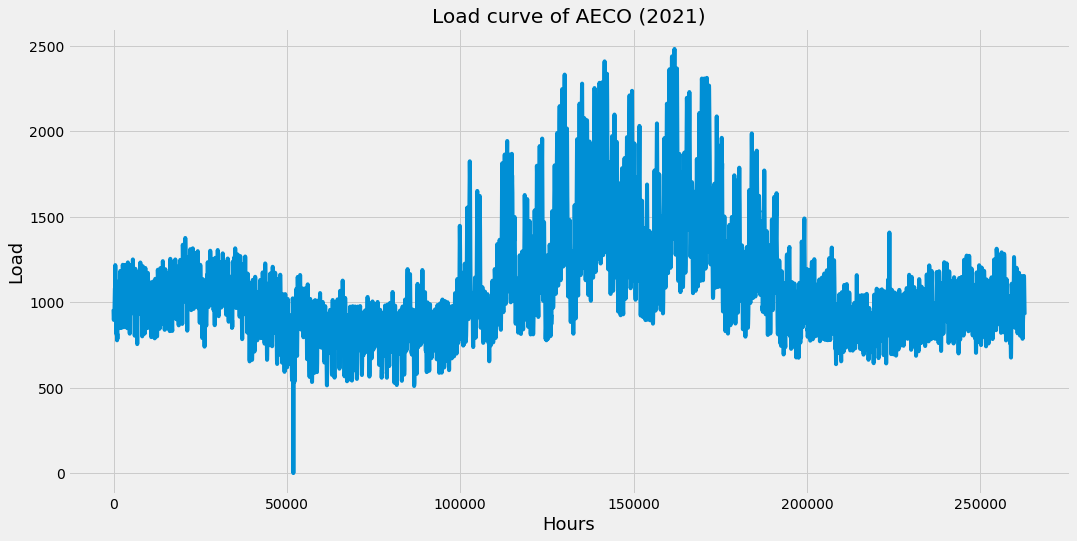

In [ ]:
#visualizing the Adj Closing Price
plt.figure(figsize = (16,8))
plt.title('Load curve of '+df.iloc[0]["load_area"]+" (2021)")
plt.plot(aapl['mw'])
plt.xlabel('Hours',fontsize=18)
plt.ylabel('Load',fontsize=18)
plt.show()

In [ ]:
#Seperate the data for Adj CLose values
data = aapl['mw']

In [ ]:
#Seperating the 95% data for training_data
training_data = data[0:int(len(data)*0.95)]
#initializing MinMaxScaler
scale = MinMaxScaler()
#Scale the data
scale.fit(training_data.values.reshape(-1,1))
scaled_training_data =scale.transform(training_data.values.reshape(-1,1))
#splitting data into X and y for training and testing
X = []
Y = []
for i in range(len(scaled_training_data) - 8):
  X.append(scaled_training_data[i:i+8,0])
  Y.append(scaled_training_data[i+8,0])
#converting x and y into numpy arrays
x = np.array(X)
y = np.array(Y)

#splitting the data into X_train,y_train,X_test and y_test
X_train = x[:int(x.shape[0]*0.95)]
X_test = x[int(x.shape[0]*0.95):]
y_train = y[:int(y.shape[0]*0.95)]
y_test = y[int(y.shape[0]*0.95):]

#reshaping the X_train and X_test data for applying LSTM model
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

In [ ]:
model = Sequential()
model.add(GRU(256, return_sequences=True ,input_shape=(8,1)))
model.add(GRU(128,return_sequences=False))
model.add(Dense(50))
model.add(Dense(1))

In [ ]:
#Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
#Train the model
model.fit(X_train, y_train, batch_size=1, epochs=2)

Epoch 1/2
7898/7898 [==============================] - 131s 16ms/step - loss: 8.6009e-04
Epoch 2/2
7898/7898 [==============================] - 93s 12ms/step - loss: 5.2328e-04


In [ ]:
#Model Predictions on training data
train_pred = model.predict(X_train)

In [ ]:
#Model Predictions on test data
pred_i = model.predict(X_test) 
pred = scale.inverse_transform(pred_i)

In [ ]:
#Calculate rmse for checking the performace of model
rmse=np.sqrt(np.mean(((pred-scale.inverse_transform(y_test.reshape(-1,1)))**2)))
print(rmse)
mape = mean_absolute_percentage_error(y_test, pred_i)
print(mape)

57.588425974097156
0.05217959486012694


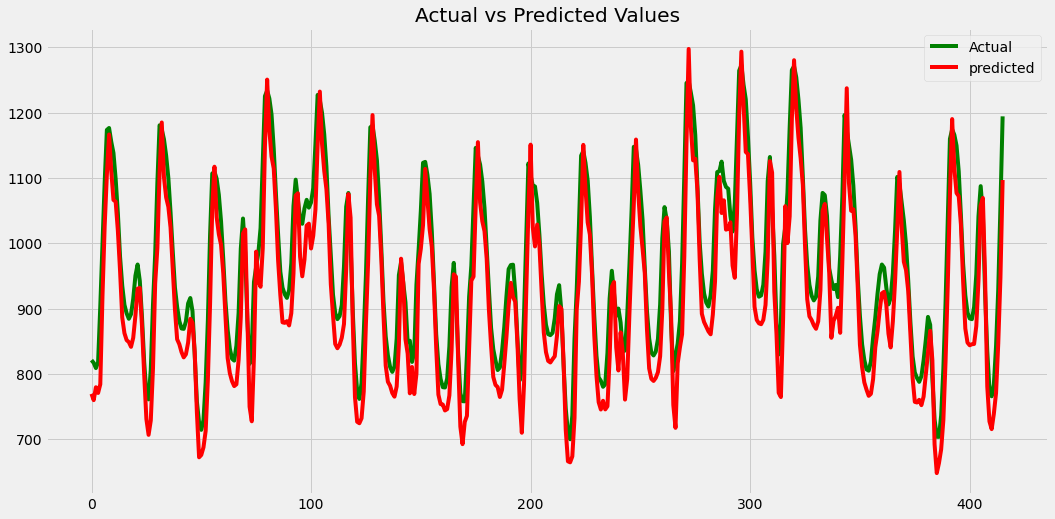

In [ ]:
#plotting actual vs predicted data
plt.figure(figsize = (16,8))
plt.plot(scale.inverse_transform(y_test.reshape(-1,1)), color = 'g',label = "Actual")
plt.plot(pred, color = 'r',label = 'predicted')
plt.legend()
plt.title("Actual vs Predicted Values")
plt.show()

Epoch 1/2
7898/7898 [==============================] - 184s 23ms/step - loss: 0.0014
Epoch 2/2
7898/7898 [==============================] - 173s 22ms/step - loss: 6.2529e-04
Epoch 1/2
7898/7898 [==============================] - 144s 18ms/step - loss: 0.0012
Epoch 2/2
7898/7898 [==============================] - 118s 15ms/step - loss: 5.3754e-04
Epoch 1/2
7898/7898 [==============================] - 113s 14ms/step - loss: 0.0012
Epoch 2/2
7898/7898 [==============================] - 114s 14ms/step - loss: 5.8643e-04
Epoch 1/2
7898/7898 [==============================] - 120s 15ms/step - loss: 0.0016
Epoch 2/2
7898/7898 [==============================] - 116s 15ms/step - loss: 0.0010
Epoch 1/2
7898/7898 [==============================] - 117s 14ms/step - loss: 9.8717e-04
Epoch 2/2
7898/7898 [==============================] - 113s 14ms/step - loss: 5.4421e-04
Epoch 1/2
7898/7898 [==============================] - 117s 14ms/step - loss: 8.7975e-04
Epoch 2/2
7898/7898 [====================

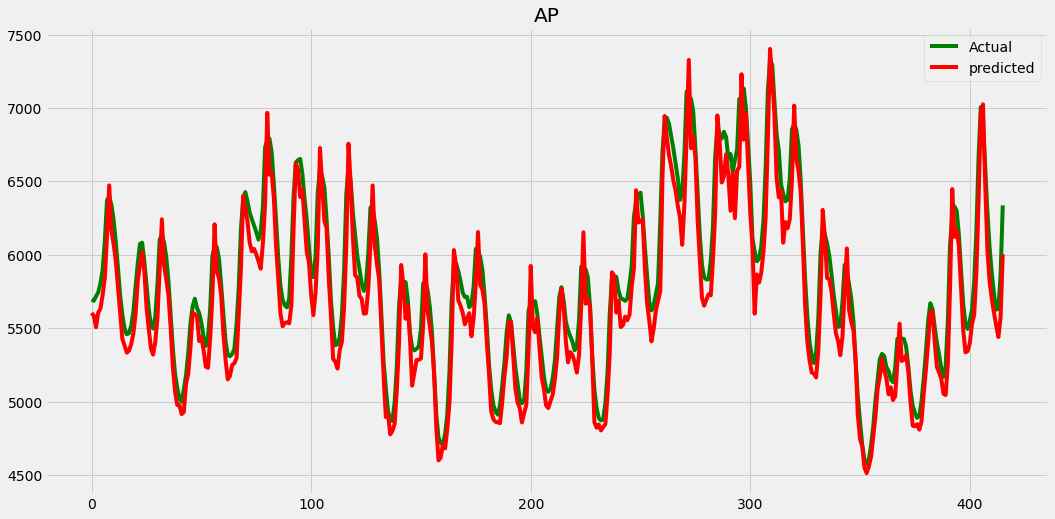

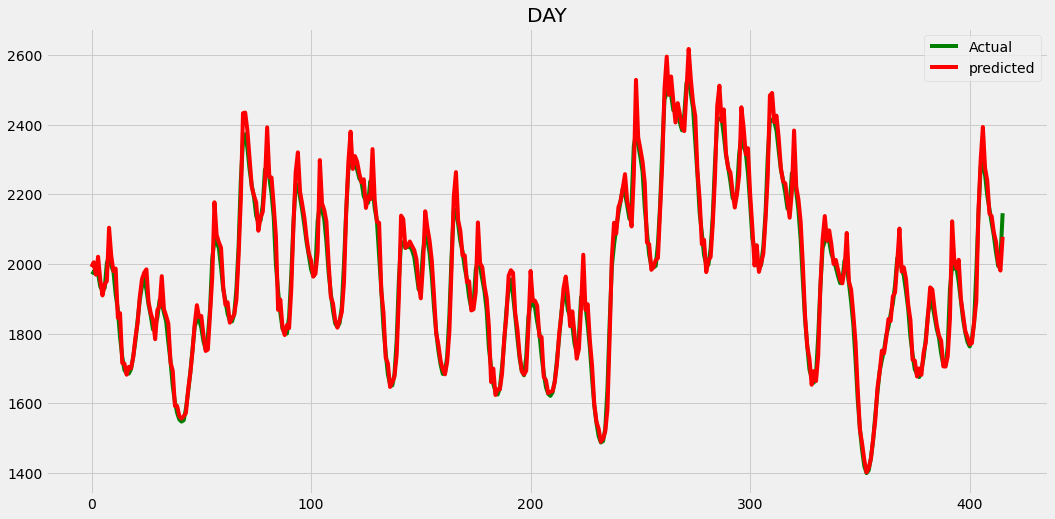

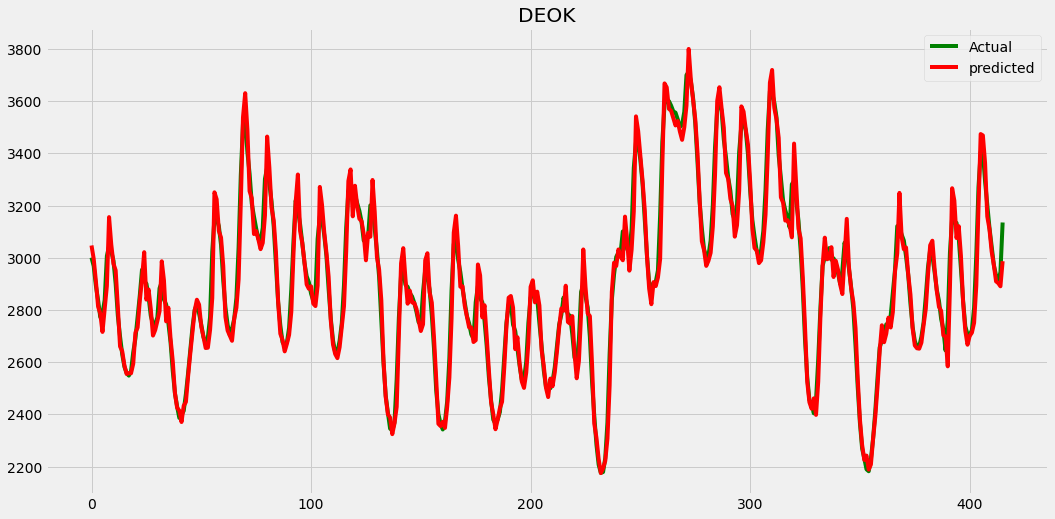

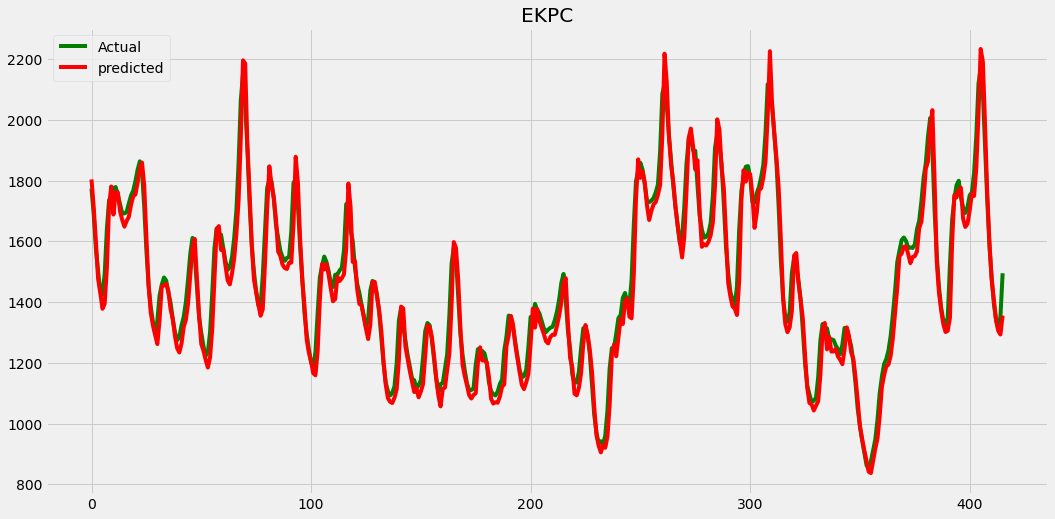

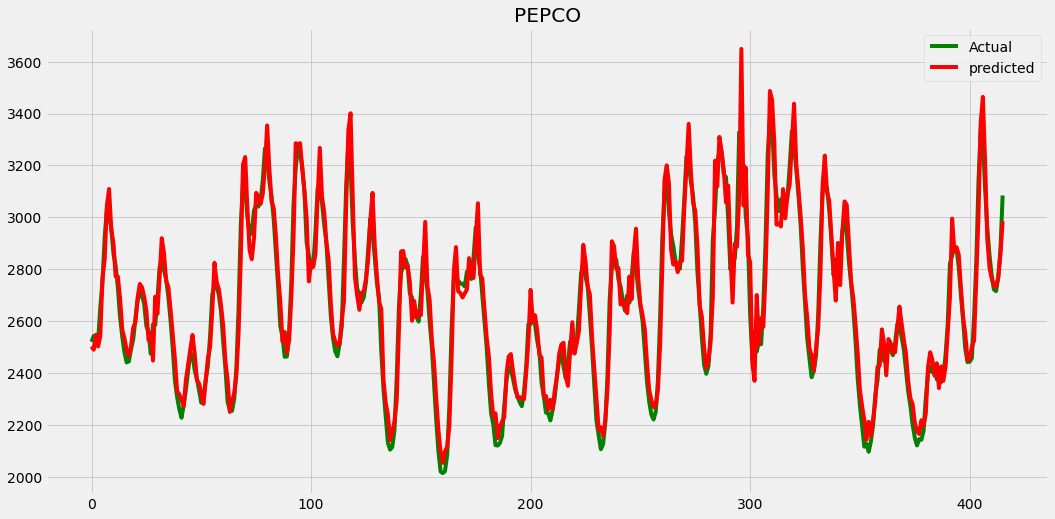

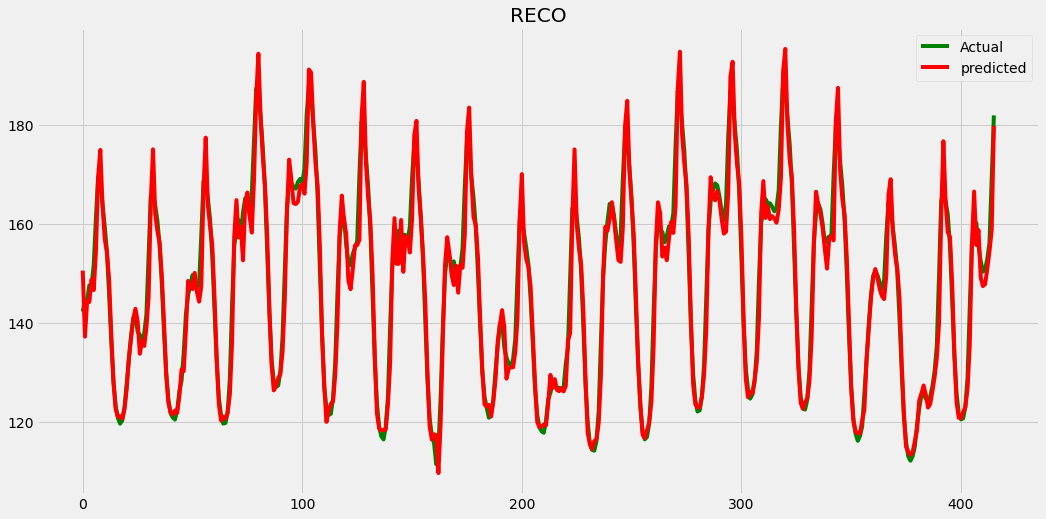

In [ ]:
#Build the LSTM network model
errors_all_LSTM=[]
for area in all_zones:
  aapl = df.loc[df['load_area'] == area]
  data = aapl['mw']
  #Seperating the 95% data for training_data
  training_data = data[0:int(len(data)*0.95)]
  #initializing MinMaxScaler
  scale = MinMaxScaler()
  #Scale the data
  scale.fit(training_data.values.reshape(-1,1))
  scaled_training_data =scale.transform(training_data.values.reshape(-1,1))
  #splitting data into X and y for training and testing
  X = []
  Y = []
  for i in range(len(scaled_training_data) - 8):
    X.append(scaled_training_data[i:i+8,0])
    Y.append(scaled_training_data[i+8,0])
  #converting x and y into numpy arrays
  x = np.array(X)
  y = np.array(Y)

  #splitting the data into X_train,y_train,X_test and y_test
  X_train = x[:int(x.shape[0]*0.95)]
  X_test = x[int(x.shape[0]*0.95):]
  y_train = y[:int(y.shape[0]*0.95)]
  y_test = y[int(y.shape[0]*0.95):]

  #reshaping the X_train and X_test data for applying LSTM model
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
  X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
  model = Sequential()
  model.add(LSTM(256, return_sequences=True ,input_shape=(8,1)))
  model.add(LSTM(128,return_sequences=False))
  model.add(Dense(50))
  model.add(Dense(1))
  #Compile the model
  model.compile(optimizer='adam', loss='mse')
  #Train the model
  model.fit(X_train, y_train, batch_size=1, epochs=2)
  #Model Predictions on training data
  train_pred = model.predict(X_train)
  #Model Predictions on test data
  pred_i = model.predict(X_test) 
  pred = scale.inverse_transform(pred_i)
  #Calculate rmse for checking the performace of model
  rmse=np.sqrt(np.mean(((pred-scale.inverse_transform(y_test.reshape(-1,1)))**2)))
  mape = mean_absolute_percentage_error(y_test, pred_i)
  errors_all_LSTM.append([area, rmse, mape])
  #plotting actual vs predicted data
  plt.figure(figsize = (16,8))
  plt.plot(scale.inverse_transform(y_test.reshape(-1,1)), color = 'g',label = "Actual")
  plt.plot(pred, color = 'r',label = 'predicted')
  plt.legend()
  plt.title(area)
  plt.savefig('2021_LSTM_'+area+'.png', bbox_inches='tight')
  # plt.show()


In [ ]:
errors_all_LSTM

[['AP', 173.17133360681115, 0.06884375057252293],
 ['DAY', 39.53571306230905, 0.03732355814418209],
 ['DEOK', 56.69808065915295, 0.04422226081267999],
 ['EKPC', 54.42669143594524, 0.07147763384574338],
 ['PEPCO', 76.09895026016697, 0.021794433883559002],
 ['RECO', 3.7604972009795428, 0.061215375031708666]]

In [ ]:
#Build the GRU network model
errors_all_GRU=[]
for area in all_zones:
  aapl = df.loc[df['load_area'] == area]
  data = aapl['mw']
  #Seperating the 95% data for training_data
  training_data = data[0:int(len(data)*0.95)]
  #initializing MinMaxScaler
  scale = MinMaxScaler()
  #Scale the data
  scale.fit(training_data.values.reshape(-1,1))
  scaled_training_data =scale.transform(training_data.values.reshape(-1,1))
  #splitting data into X and y for training and testing
  X = []
  Y = []
  for i in range(len(scaled_training_data) - 8):
    X.append(scaled_training_data[i:i+8,0])
    Y.append(scaled_training_data[i+8,0])
  #converting x and y into numpy arrays
  x = np.array(X)
  y = np.array(Y)

  #splitting the data into X_train,y_train,X_test and y_test
  X_train = x[:int(x.shape[0]*0.95)]
  X_test = x[int(x.shape[0]*0.95):]
  y_train = y[:int(y.shape[0]*0.95)]
  y_test = y[int(y.shape[0]*0.95):]

  #reshaping the X_train and X_test data for applying LSTM model
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
  X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
  model = Sequential()
  model.add(GRU(256, return_sequences=True ,input_shape=(8,1)))
  model.add(GRU(128,return_sequences=False))
  model.add(Dense(50))
  model.add(Dense(1))
  #Compile the model
  model.compile(optimizer='adam', loss='mse')
  #Train the model
  model.fit(X_train, y_train, batch_size=1, epochs=2)
  #Model Predictions on training data
  train_pred = model.predict(X_train)
  #Model Predictions on test data
  pred_i = model.predict(X_test) 
  pred = scale.inverse_transform(pred_i)
  #Calculate rmse for checking the performace of model
  rmse=np.sqrt(np.mean(((pred-scale.inverse_transform(y_test.reshape(-1,1)))**2)))
  mape = mean_absolute_percentage_error(y_test, pred_i)
  errors_all_GRU.append([area, rmse, mape])
  #plotting actual vs predicted data
  plt.figure(figsize = (16,8))
  plt.plot(scale.inverse_transform(y_test.reshape(-1,1)), color = 'g',label = "Actual")
  plt.plot(pred, color = 'r',label = 'predicted')
  plt.legend()
  plt.title(area)
  plt.savefig('2021_GRU_'+area+'.png', bbox_inches='tight')
  # plt.show()


In [ ]:
errors_all_GRU

[['AP', 160.06381393042912, 0.062260577601167905],
 ['DAY', 39.80064032959343, 0.03783414548769193],
 ['DEOK', 57.27661950580304, 0.0443621783569862],
 ['EKPC', 55.78614878010071, 0.07226902866085844],
 ['PEPCO', 78.21714978609, 0.02227193002046041],
 ['RECO', 3.773820936745413, 0.06237307009720064]]

Epoch 1/2
47470/47470 [==============================] - 573s 12ms/step - loss: 5.8822e-04
Epoch 2/2
47470/47470 [==============================] - 552s 12ms/step - loss: 3.7700e-04
Epoch 1/2
47470/47470 [==============================] - 569s 12ms/step - loss: 6.3841e-04
Epoch 2/2
47470/47470 [==============================] - 565s 12ms/step - loss: 4.0516e-04
Epoch 1/2
47470/47470 [==============================] - 558s 12ms/step - loss: 6.2503e-04
Epoch 2/2
47470/47470 [==============================] - 553s 12ms/step - loss: 4.0375e-04
Epoch 1/2
47470/47470 [==============================] - 563s 12ms/step - loss: 6.2395e-04
Epoch 2/2
47470/47470 [==============================] - 559s 12ms/step - loss: 4.6138e-04
Epoch 1/2
47470/47470 [==============================] - 558s 12ms/step - loss: 4.0343e-04
Epoch 2/2
47470/47470 [==============================] - 564s 12ms/step - loss: 2.2643e-04
Epoch 1/2
47470/47470 [==============================] - 556s 12ms/step - loss: 3.5367e-04

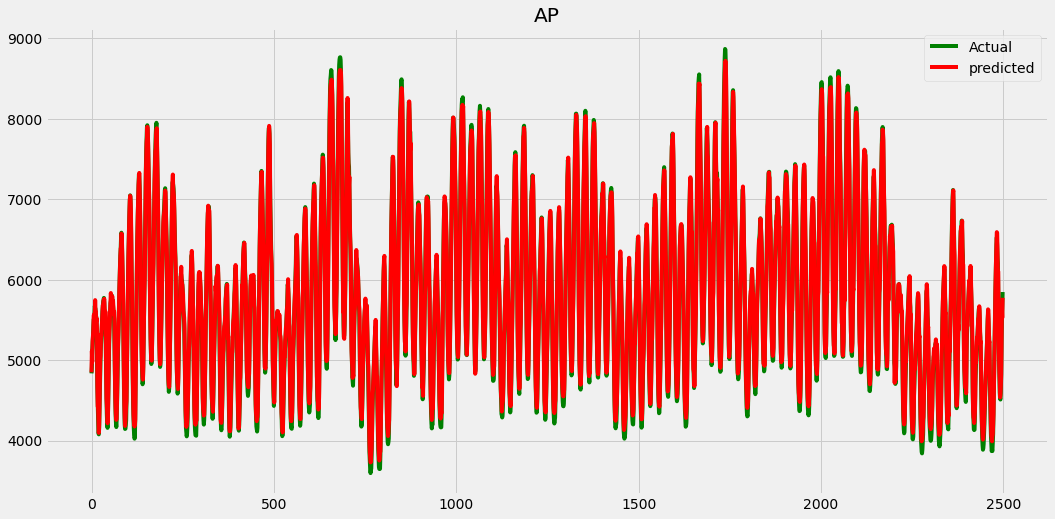

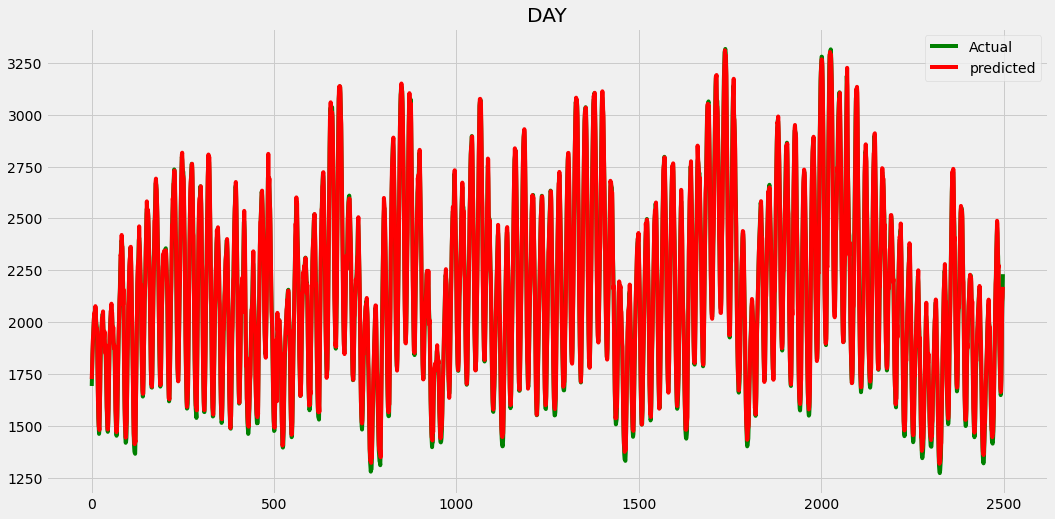

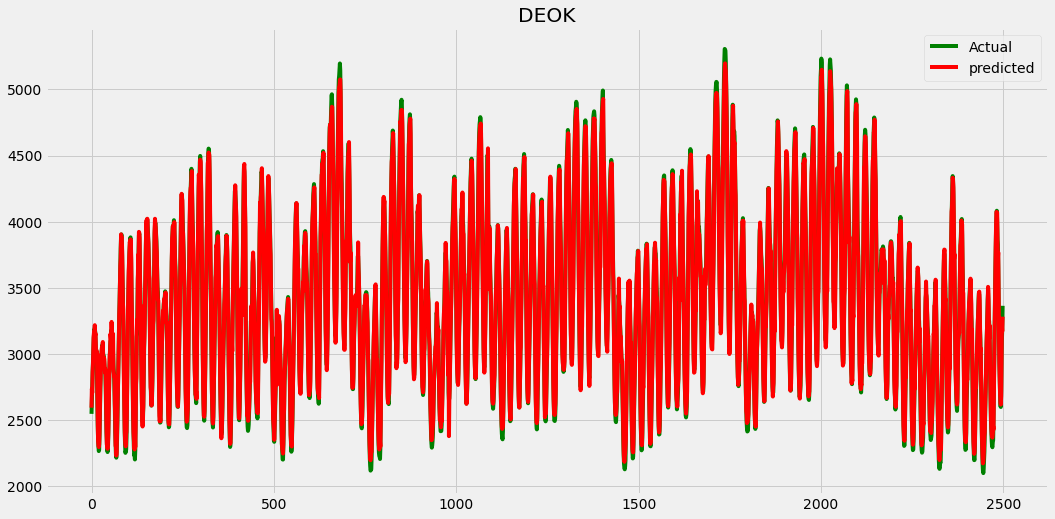

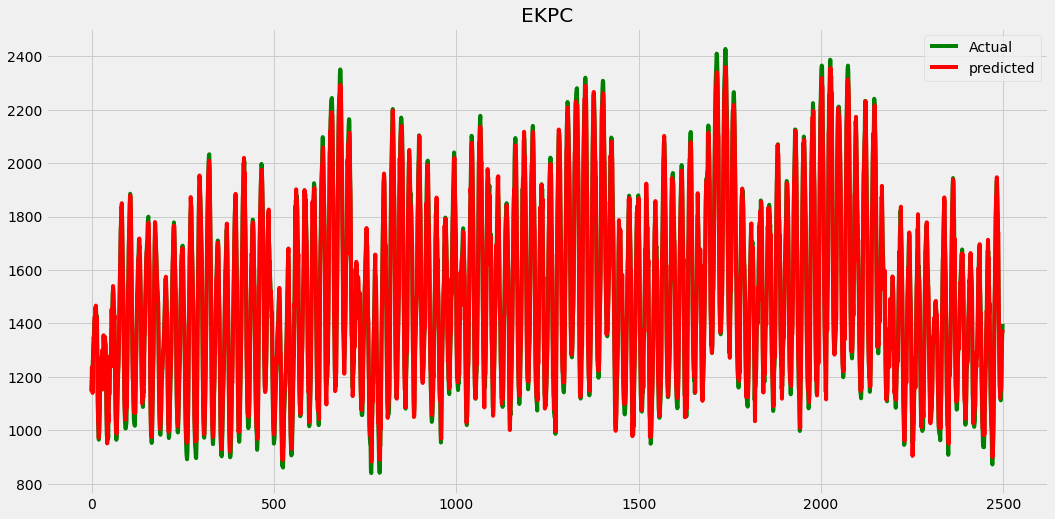

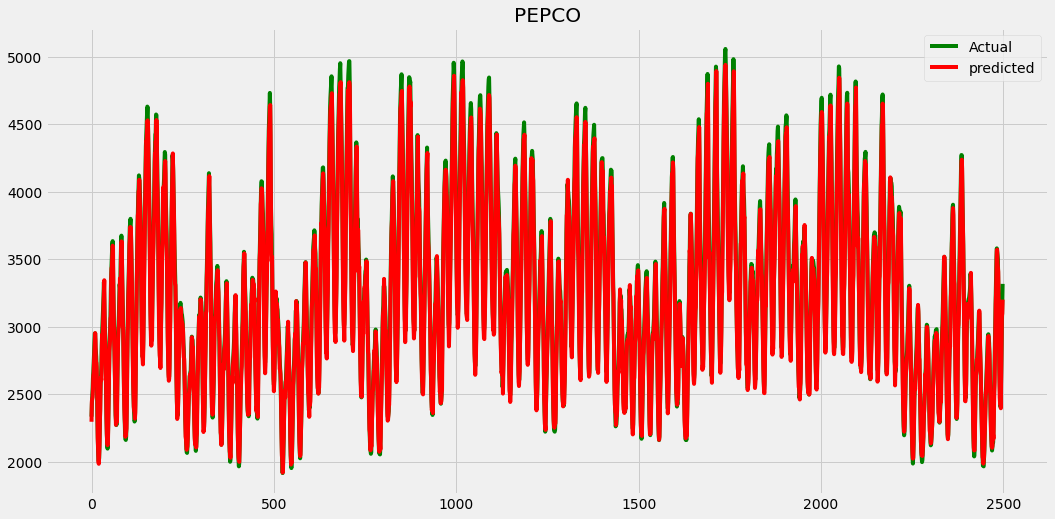

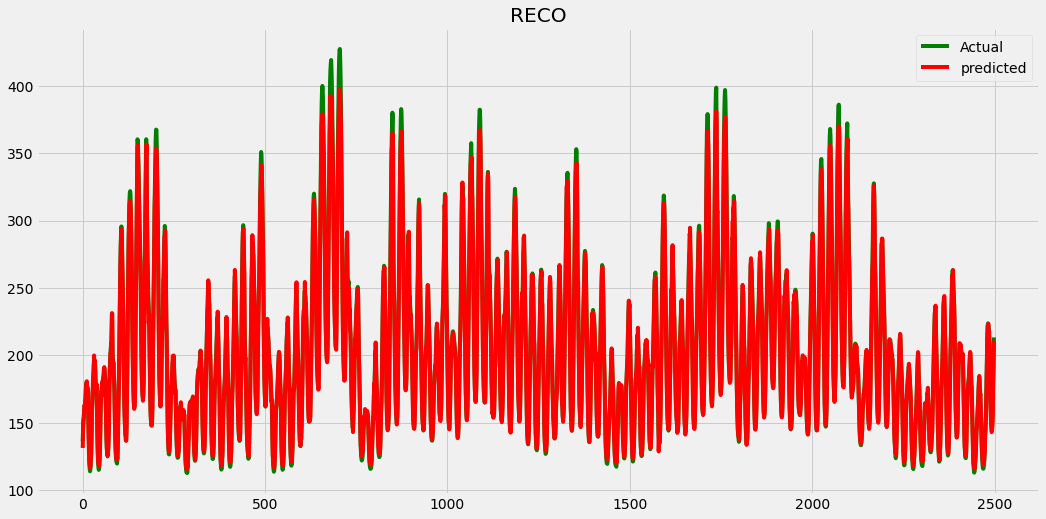

In [ ]:
#Build the GRU network model 2016-2021
errors_final_GRU=[]
for aapl in final_dfs:
  # aapl = df.loc[df['load_area'] == area]
  data = aapl['mw']
  #Seperating the 95% data for training_data
  training_data = data[0:int(len(data)*0.95)]
  #initializing MinMaxScaler
  scale = MinMaxScaler()
  #Scale the data
  scale.fit(training_data.values.reshape(-1,1))
  scaled_training_data =scale.transform(training_data.values.reshape(-1,1))
  #splitting data into X and y for training and testing
  X = []
  Y = []
  for i in range(len(scaled_training_data) - 8):
    X.append(scaled_training_data[i:i+8,0])
    Y.append(scaled_training_data[i+8,0])
  #converting x and y into numpy arrays
  x = np.array(X)
  y = np.array(Y)

  #splitting the data into X_train,y_train,X_test and y_test
  X_train = x[:int(x.shape[0]*0.95)]
  X_test = x[int(x.shape[0]*0.95):]
  y_train = y[:int(y.shape[0]*0.95)]
  y_test = y[int(y.shape[0]*0.95):]

  #reshaping the X_train and X_test data for applying LSTM model
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
  X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
  model = Sequential()
  model.add(GRU(256, return_sequences=True ,input_shape=(8,1)))
  model.add(GRU(128,return_sequences=False))
  model.add(Dense(50))
  model.add(Dense(1))
  #Compile the model
  model.compile(optimizer='adam', loss='mse')
  #Train the model
  model.fit(X_train, y_train, batch_size=1, epochs=2)
  #Model Predictions on training data
  train_pred = model.predict(X_train)
  #Model Predictions on test data
  pred_i = model.predict(X_test) 
  pred = scale.inverse_transform(pred_i)
  #Calculate rmse for checking the performace of model
  rmse=np.sqrt(np.mean(((pred-scale.inverse_transform(y_test.reshape(-1,1)))**2)))
  mape = mean_absolute_percentage_error(y_test, pred_i)
  errors_final_GRU.append([aapl.iloc[0]["load_area"], rmse, mape])
  #plotting actual vs predicted data
  plt.figure(figsize = (16,8))
  plt.plot(scale.inverse_transform(y_test.reshape(-1,1)), color = 'g',label = "Actual")
  plt.plot(pred, color = 'r',label = 'predicted')
  plt.legend()
  plt.title(aapl.iloc[0]["load_area"])
  plt.savefig('2016_21_GRU_'+aapl.iloc[0]["load_area"]+'.png', bbox_inches='tight')
  # plt.show()


In [ ]:
errors_final_GRU

[['AP', 103.28600058505292, 0.04688178912582795],
 ['DAY', 35.0006946451269, 0.03224097287736853],
 ['DEOK', 64.86729529994885, 0.03804892326560219],
 ['EKPC', 49.06803278649312, 0.06304418042163044],
 ['PEPCO', 80.4887732400163, 0.01908353073382362],
 ['RECO', 5.757926967979247, 0.03337823690212819]]

In [ ]:
#Build the LSTM network model 2016-2021
errors_final_LSTM=[]
for aapl in final_dfs:
  # aapl = df.loc[df['load_area'] == area]
  data = aapl['mw']
  #Seperating the 95% data for training_data
  training_data = data[0:int(len(data)*0.95)]
  #initializing MinMaxScaler
  scale = MinMaxScaler()
  #Scale the data
  scale.fit(training_data.values.reshape(-1,1))
  scaled_training_data =scale.transform(training_data.values.reshape(-1,1))
  #splitting data into X and y for training and testing
  X = []
  Y = []
  for i in range(len(scaled_training_data) - 8):
    X.append(scaled_training_data[i:i+8,0])
    Y.append(scaled_training_data[i+8,0])
  #converting x and y into numpy arrays
  x = np.array(X)
  y = np.array(Y)

  #splitting the data into X_train,y_train,X_test and y_test
  X_train = x[:int(x.shape[0]*0.95)]
  X_test = x[int(x.shape[0]*0.95):]
  y_train = y[:int(y.shape[0]*0.95)]
  y_test = y[int(y.shape[0]*0.95):]

  #reshaping the X_train and X_test data for applying LSTM model
  X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
  X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
  model = Sequential()
  model.add(LSTM(256, return_sequences=True ,input_shape=(8,1)))
  model.add(LSTM(128,return_sequences=False))
  model.add(Dense(50))
  model.add(Dense(1))
  #Compile the model
  model.compile(optimizer='adam', loss='mse')
  #Train the model
  model.fit(X_train, y_train, batch_size=1, epochs=2)
  #Model Predictions on training data
  train_pred = model.predict(X_train)
  #Model Predictions on test data
  pred_i = model.predict(X_test) 
  pred = scale.inverse_transform(pred_i)
  #Calculate rmse for checking the performace of model
  rmse=np.sqrt(np.mean(((pred-scale.inverse_transform(y_test.reshape(-1,1)))**2)))
  mape = mean_absolute_percentage_error(y_test, pred_i)
  errors_final_LSTM.append([aapl.iloc[0]["load_area"], rmse, mape])
  #plotting actual vs predicted data
  plt.figure(figsize = (16,8))
  plt.plot(scale.inverse_transform(y_test.reshape(-1,1)), color = 'g',label = "Actual")
  plt.plot(pred, color = 'r',label = 'predicted')
  plt.legend()
  plt.title(aapl.iloc[0]["load_area"])
  plt.savefig('2016_21_LSTM_'+aapl.iloc[0]["load_area"]+'.png', bbox_inches='tight')  # plt.show()


Epoch 1/2
47470/47470 [==============================] - 811s 17ms/step - loss: 6.6827e-04
Epoch 2/2
47470/47470 [==============================] - 723s 15ms/step - loss: 3.9887e-04
Epoch 1/2
37709/47470 [======================>.......] - ETA: 2:32 - loss: 7.6651e-04

In [ ]:
errors_final_LSTM

In [ ]:
print()